In [35]:
%matplotlib widget
import pickle
import pandas as pd
import numpy as np
from capsubot_env.capsubot import Capsubot
from capsubot_env.capsubot_env_to_point import CapsubotEnvToPoint
import matplotlib.pyplot as plt
# from tqdm import tqdm
from typing import List

In [36]:
from brute_mpc import *
def get_classic_optimal(timestamps, model_type=1):
    if model_type == 1:
        T=0.0441
        tau= 1 - 0.785
    if model_type == 0:
        T=0.097
        tau= 0.14

    force_func = lambda t: classic_force_model(t, T, tau)
    dt = MIN_DT
    duration = timestamps[-1]
    agent = Capsubot(dt=dt, frame_skip=1, model=model_type)
    agent.reset()

    classic_data = {"states" : [], "actions" : [], "timestamps" : []}
    while agent._total_time <= duration:
        action = force_func(agent.get_total_time)
        agent.step(action=action)
        classic_data["states"].append(agent.get_state)
        classic_data["actions"].append(action)
        classic_data["timestamps"].append(agent.get_total_time)

    return classic_data

In [66]:
# Read data from file
data = {}
data_path = "/Users/amnunuparov/repos/mpc_rl_capsubot/mpc_brute_time_optimal_0_fs_2000_dur_300_T_100.pkl"
with open(data_path, 'rb') as fp:
    data = pickle.load(fp)
model_type = 0
# if data_path.startswith('mpc_max_average_'):    
#     model_type = int(data_path.split('_')[3])
# elif data_path.startswith('mpc_dist_'):    
#     data_path = "prefix_" + data_path
#     model_type = int(data_path.split('_')[3])
# else:
#     raise Exception("wrong data path!")

dCoordinate 0.009013121632211712
av speed 0.020187427550006045, 0.5m time = 24.767890745933613 better on 0.16287025057638504


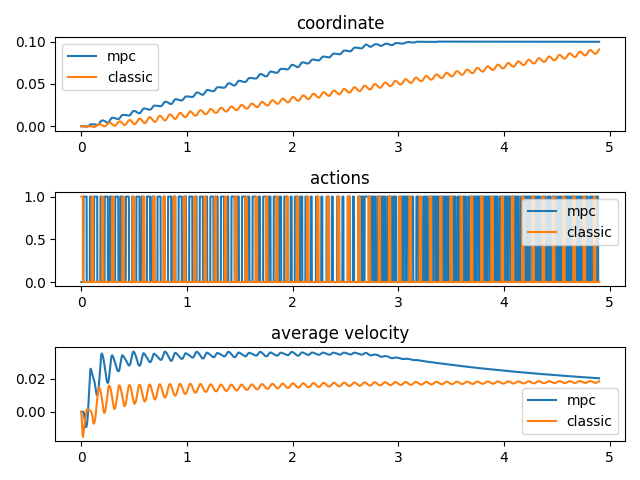

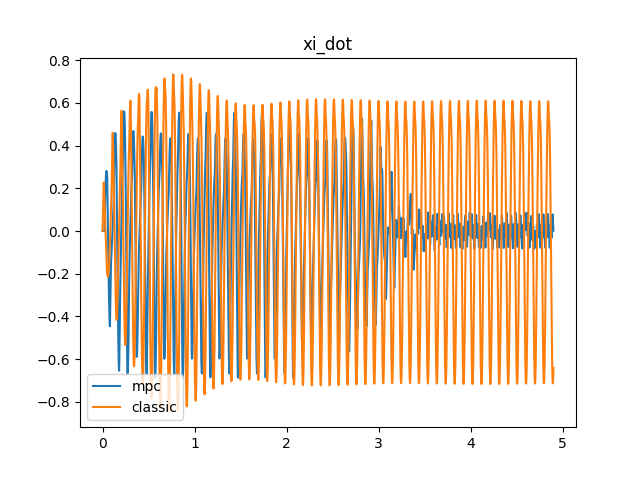

In [67]:

fig, axs = plt.subplots(3)
axs[0].plot(data["timestamps"], [x[0] for x in data["states"]], label="mpc")
axs[1].plot(data["timestamps"], data["actions"], label="mpc")
axs[2].plot(data["timestamps"], [x[0]/t for x, t in zip(data["states"], data["timestamps"])], label="mpc")
classic_data = get_classic_optimal(data["timestamps"], model_type=model_type)
axs[0].plot(classic_data["timestamps"], [x[0] for x in classic_data["states"]], label="classic")
axs[1].plot(classic_data["timestamps"], classic_data["actions"], label="classic")
axs[2].plot(classic_data["timestamps"], [x[0]/t for x, t in zip(classic_data["states"], classic_data["timestamps"])], label="classic")

for ax in axs:
    ax.legend()

axs[0].set_title(f'coordinate')
axs[1].set_title(f'actions')
axs[2].set_title(f'average velocity')
fig.tight_layout()

print(f'dCoordinate {data["states"][-1][0] - classic_data["states"][-1][0]}')


plt.figure()
plt.plot(data["timestamps"], [x[3] for x in data["states"]], label="mpc")
plt.plot(classic_data["timestamps"], [x[3] for x in classic_data["states"]], label="classic")
plt.legend()
plt.title("xi_dot")

av_speed = data["states"][-1][0]/data["timestamps"][-1]*0.99
classic_speed = 0.01736
print(f'av speed {av_speed}, 0.5m time = {0.5/av_speed} better on {(av_speed - classic_speed)/classic_speed}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


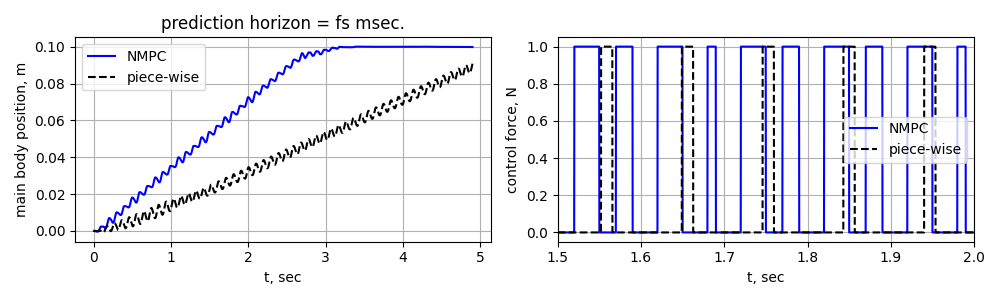

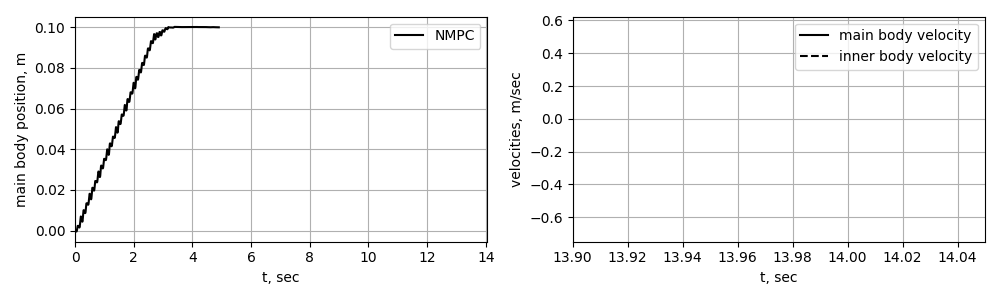

In [68]:
mpc_original = [x[0]/t for x, t in zip(data["states"], data["timestamps"])]
# plt.plot(data["timestamps"], mpc_original, label="mpc")

class_vx = [x[0]/t for x, t in zip(classic_data["states"], classic_data["timestamps"])]


modified_data = data.copy()
found = False
for idx in range(len(modified_data["states"])):
    # if (idx < 1 or modified_data["states"][idx - 1][0] < 0.5):
    #     continue
    # print(modified_data["states"][idx][0])
    if (modified_data["states"][idx][0] < 0.5):
        continue
    

    # if (not found or (modified_data["states"][idx][1] > 0.01 and modified_data["states"][idx][3] > 0.01)):
        # continue
    found = True
    modified_data["states"][idx][0] = modified_data["states"][idx - 1][0]
    modified_data["states"][idx][1] = modified_data["states"][idx - 1][1]*0.9
    modified_data["states"][idx][2] = modified_data["states"][idx - 1][2]*0.9
    modified_data["states"][idx][3] = modified_data["states"][idx - 1][3]*0.9
    
# mpc_modified = [mpc]

prediction_horizon = data_path.split("_")[7]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
row_idx = 0
axs[row_idx].plot(modified_data["timestamps"], [x[0] for x in modified_data["states"]], label="NMPC", color="b")
axs[row_idx].plot(classic_data["timestamps"], [x[0] for x in classic_data["states"]], label="piece-wise", color="k", linestyle="--")
axs[row_idx].grid()
axs[row_idx].legend()
axs[row_idx].set_xlabel("t, sec")
axs[row_idx].set_ylabel("main body position, m")
axs[row_idx].set_title(f"prediction horizon = {prediction_horizon} msec.")

row_idx = 1
axs[row_idx].plot(modified_data["timestamps"], modified_data["actions"], label="NMPC", color="b")
axs[row_idx].plot(classic_data["timestamps"], classic_data["actions"], label="piece-wise", color="k", linestyle="--")
axs[row_idx].grid()
axs[row_idx].set_xlabel("t, sec")
axs[row_idx].set_ylabel("control force, N")
axs[row_idx].legend()
# axs[row_idx].title(f"prediction horizon = {prediction_horizon} msec.")
axs[row_idx].set_xlim((1.5, 2.0))
fig.tight_layout()
fig.align_ylabels()
fig.savefig(f'mpc_dur_{prediction_horizon}.eps', format='eps')


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
row_idx = 0
axs[row_idx].plot(data["timestamps"], [x[0] for x in data["states"]], label="NMPC", color="k")
axs[row_idx].grid()
axs[row_idx].set_xlabel("t, sec")
axs[row_idx].set_ylabel("main body position, m")
axs[row_idx].set_xlim((0.0, 14.05))
axs[row_idx].legend()
# axs[row_idx].set_title(f"prediction horizon = {prediction_horizon} msec.")

row_idx = 1
axs[row_idx].plot(data["timestamps"], [x[1] for x in data["states"]], label="main body velocity", color="k")
axs[row_idx].plot(data["timestamps"], [x[3] for x in data["states"]], label="inner body velocity", color="k", linestyle="--")
axs[row_idx].grid()
axs[row_idx].legend()
axs[row_idx].set_xlabel("t, sec")
axs[row_idx].set_ylabel("velocities, m/sec")
# axs[row_idx].title(f"prediction horizon = {prediction_horizon} msec.")
axs[row_idx].set_xlim((13.9, 14.05))
fig.tight_layout()
fig.align_ylabels()
fig.savefig(f'mpc_vel_dur_{prediction_horizon}.eps', format='eps')


# plt.plot(classic_data["timestamps"], class_vx, label="статья", color="gray", linestyle="--")


# plt.figure()
# plt.plot(data["timestamps"], mpc_modified, label="NMPC", color="k")
# # plt.plot(classic_data["timestamps"], class_vx, label="статья", color="gray", linestyle="--")
# plt.legend()
# plt.xlim((0.0, 1.0))
# plt.xlabel("t, sec")
# plt.ylabel("average movement velocity, m/sec")


# plt.figure()
# plt.plot(data["timestamps"], mpc_modified, label="NMPC", color="k")
# # plt.plot(classic_data["timestamps"], class_vx, label="статья", color="gray", linestyle="--")
# plt.legend()
# plt.xlim((0.0, 1.0))
# plt.xlabel("t, sec")
# plt.ylabel("average movement velocity, m/sec")

In [166]:
new_timestamps = [0, 5.0]
classic_data = get_classic_optimal(new_timestamps)

kdx = 0
while classic_data["states"][kdx][0] <= 0.3:
    kdx += 1
mean_v = [x[0] for x in classic_data["states"]]
plt.plot(classic_data["timestamps"][:kdx], mean_v[:kdx], label="classic")
classic_data["timestamps"][:kdx][-1]
plt.xlabel("t, с")
plt.ylabel("координата корпуса, м")

Text(1056.0588604011575, 0.5, 'координата корпуса, м')

In [2]:
def get_step_data(ts, vals):
    step_t, step_x = [], []
    for i in range(len(ts)):
        if i > 1:
            step_t.append(ts[i])
            step_x.append(vals[i - 1])
        step_t.append(ts[i])
        step_x.append(vals[i])
    return step_t, step_x

In [21]:
# Read data from file
p1_data = {}
p1_data_path = "/Users/amnunuparov/repos/mpc_rl_capsubot/results/max_average_sh_0_dur_300_T_20000_dym_23_04_14_hm_22_50.pkl"
with open(p1_data_path, 'rb') as fp:
    p1_data = pickle.load(fp)


In [31]:
# Read data from file
p2_data = {}
p2_data_path = "/Users/amnunuparov/repos/mpc_rl_capsubot/src/MPC/../../results/min_time_sh_0_dur_300_T_20000_dym_23_04_14_hm_23_30.pkl"
with open(p2_data_path, 'rb') as fp:
    p2_data = pickle.load(fp)


(-0.08474999999999919, 1.8897499999999827)

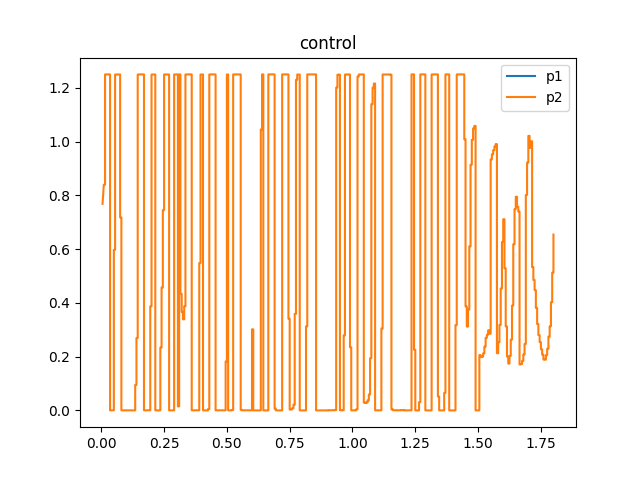

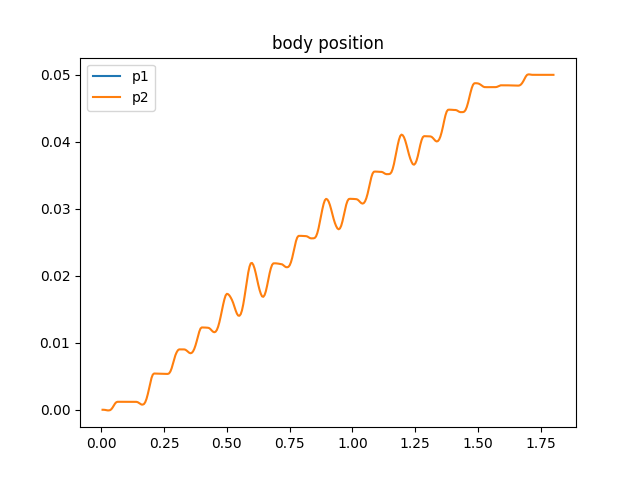

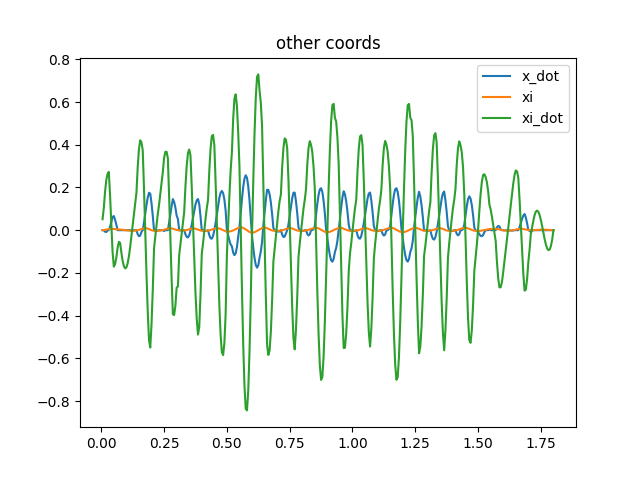

In [33]:
xlims = None
plt.figure()
plt.plot(*get_step_data(p1_data['timestamps'], p1_data['actions']), label="p1")
plt.plot(*get_step_data(p2_data['timestamps'], p2_data['actions']), label="p2")
plt.legend()
plt.title("control")
plt.xlim(xlims)

plt.figure()
plt.plot(p1_data['timestamps'], [x[0] for x in p1_data['states']], label="p1")
plt.plot(p2_data['timestamps'], [x[0] for x in p2_data['states']], label="p2")
plt.legend()
plt.title("body position")
plt.xlim(xlims)

plt.figure()
# plt.plot(data['timestamps'], [x[1:] for x in data['states']])
plt.plot(p2_data['timestamps'], [x[1:] for x in p2_data['states']], label=["x_dot", "xi", "xi_dot"])
plt.legend()
plt.title("other coords")
plt.xlim(xlims)




In [11]:
print(data['states'][-1][0])


0.02164011827389624
